# Gender Prediction based on Bag of Words and TF-IDF

Two conditions:
- each prompt is fed separately
- all prompts of a user are concatenated and then vectorized

- expanded prompts without capitalization, new lines and punctuation
- stopword removal cauased accuracy to drop to 40 in tf-idf and bow
- Pos Label is 1

In [67]:
import sqlite3
import pandas as pd
from helpers.normalization import remove_punctuation_and_newlines, remove_capitalization

conn = sqlite3.connect('../../giicg.db')

prompts = pd.read_sql("SELECT * FROM expanded_prompts", conn)
prompts = prompts[prompts['gender'].isin(['Woman (cisgender)', 'Man (cisgender)'])].reset_index()
conn.close()
prompts

,index,message_id,conversation_id,role,message_text,conversational,code,other,gender,user_id,language
0,0,1,1,user,"parsing data from python iterator, how it coul...","parsing data from python iterator, how it coul...",,,Man (cisgender),6,en
1,1,730,32,user,Write python function to do operations with in...,Write python function to do operations with in...,,report_dt\tsource\tmetric_name\tmetric_num\tme...,Man (cisgender),6,en
2,2,1133,55,user,Write shortest tutorial on creating RAG on ema...,Write shortest tutorial on creating RAG on ema...,,,Man (cisgender),6,en
3,3,1135,55,user,what is FAISS,what is FAISS,,,Man (cisgender),6,en
4,4,1137,55,user,Transform given code to process large .mbox file,Transform given code to process large .mbox file,,Transform given code to process large .mbox file,Man (cisgender),6,en
...,...,...,...,...,...,...,...,...,...,...,...
741,748,1646,82,user,"def run_query(query, n_results):\n query_em...",this is my code. I want to: Get nodes and edge...,"def run_query(query, n_results):\n query_em...",,Man (cisgender),92,en
742,749,1845,37,user,\n nun möchte ich judgement balancing m...,Now I want to bring judgement balancing into t...,,,Woman (cisgender),29,de
743,750,1847,37,user,\n ich sehe keine veränderung im Plot. Was ...,I do not see any change in the plot.,,,Woman (cisgender),29,de
744,751,1849,2,user,\n I am working on the problem of reconstru...,\n I am working on the problem of reconstru...,,Classic CV - Drone navigation\nIf you ever tho...,Man (cisgender),8,en


## Concatenate prompts per user

In [68]:
user_prompts = (
    prompts.groupby(['user_id', 'gender'])['conversational']
    .apply(' '.join)
    .reset_index()    # Reset index to create a DataFrame
)

user_prompts.columns = ['user_id', 'gender', 'combined_prompts']

user_prompts

,user_id,gender,combined_prompts
0,6,Man (cisgender),"parsing data from python iterator, how it coul..."
1,8,Man (cisgender),\n I am working on the problem of reconstru...
2,11,Woman (cisgender),Can you adapt the following code so that inste...
3,15,Man (cisgender),SET_ALL_TABLES action is currently not fetchin...
4,16,Woman (cisgender),I want to use Dummy Hot encoding to replace th...
5,25,Man (cisgender),what is the best way to encode and compress a ...
6,28,Woman (cisgender),I have a pandas dataframe like this:\n\nI want...
7,29,Woman (cisgender),Now I want to bring judgement balancing into t...
8,31,Man (cisgender),How can I make use of an ObservableHQDatabaseC...
9,34,Man (cisgender),Blender and Python. I have a collection of hun...


## Subsample from user 73

In [69]:
def subsample(df, id):
    user_73 = df[df['user_id'] == id]
    other_users = df[df['user_id'] != id]

    user_73_sampled = user_73.sample(n=19, random_state=42)

    prompts = pd.concat([other_users, user_73_sampled], ignore_index=True)

    subsampled_messages_per_user = prompts.groupby('user_id')['message_id'].nunique().reset_index(name='num_messages')
    subsampled_with_gender = subsampled_messages_per_user.merge(
        prompts[['user_id', 'gender']].drop_duplicates(),
        on='user_id',
        how='left'
    )
    print(subsampled_with_gender.groupby(['gender']).sum())

    users_per_gender = prompts.groupby('gender')['user_id'].nunique().reset_index(name='num_users')
    print(users_per_gender)

    return prompts

prompts = subsample(prompts, 73)
# prompts = subsample(prompts, 91)
# prompts = subsample(prompts, 34)
# prompts = subsample(prompts, 79)
# prompts = subsample(prompts, 55)
# prompts = subsample(prompts, 89)
# prompts = subsample(prompts, 16)
# prompts = subsample(prompts, 28)
# prompts = subsample(prompts, 77)
# prompts = subsample(prompts, 73)
# prompts = subsample(prompts, 48)
# prompts = subsample(prompts, 83)
# prompts = subsample(prompts, 90)
# prompts = subsample(prompts, 11)
# prompts = subsample(prompts, 47)



prompts

                   user_id  num_messages
gender                                  
Man (cisgender)        780           282
Woman (cisgender)      706           254
              gender  num_users
0    Man (cisgender)         15
1  Woman (cisgender)         13


,index,message_id,conversation_id,role,message_text,conversational,code,other,gender,user_id,language
0,0,1,1,user,"parsing data from python iterator, how it coul...","parsing data from python iterator, how it coul...",,,Man (cisgender),6,en
1,1,730,32,user,Write python function to do operations with in...,Write python function to do operations with in...,,report_dt\tsource\tmetric_name\tmetric_num\tme...,Man (cisgender),6,en
2,2,1133,55,user,Write shortest tutorial on creating RAG on ema...,Write shortest tutorial on creating RAG on ema...,,,Man (cisgender),6,en
3,3,1135,55,user,what is FAISS,what is FAISS,,,Man (cisgender),6,en
4,4,1137,55,user,Transform given code to process large .mbox file,Transform given code to process large .mbox file,,Transform given code to process large .mbox file,Man (cisgender),6,en
...,...,...,...,...,...,...,...,...,...,...,...
531,501,1674,87,user,Accuracy: 1.0\n Count: 2\nMetrics for neptune...,these are the results. i to calculate a statis...,,Accuracy: 1.0\n Count: 2\nMetrics for neptune...,Woman (cisgender),73,en
532,416,1290,65,user,how are we currently processing non numerical ...,how are we currently processing non numerical ...,"def perform_optics_clustering(file_path, outpu...",,Woman (cisgender),73,en
533,425,1314,65,user,what is the reachability score,what is the reachability score,,,Woman (cisgender),73,en
534,309,372,21,user,"my features are saved in ""train_features.npy"" ...","my features are saved in ""train_features.npy"" ...",,,Woman (cisgender),73,en


## Prepare Data

In [70]:
from sklearn.base import BaseEstimator, TransformerMixin

X_user = user_prompts["combined_prompts"]
y_user = user_prompts['gender'].apply(lambda x: 1 if x == 'Woman (cisgender)' else 0)

X_prompt = prompts["conversational"]
y_prompt = prompts['gender'].apply(lambda x: 1 if x == 'Woman (cisgender)' else 0)
groups = prompts['user_id']


class Cleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self  # stateless
    def transform(self, X):
        def clean(text):
            text = remove_punctuation_and_newlines(text)
            text = remove_capitalization(text)
            return text
        return [clean(t) for t in X]

groups





0       6
1       6
2       6
3       6
4       6
       ..
531    73
532    73
533    73
534    73
535    73
Name: user_id, Length: 536, dtype: int64

## Custom stratified group split

In [71]:
import numpy as np
from collections import defaultdict, Counter

def stratified_group_k_fold(X, y, groups, n_splits, random_state=None):
    """
    Custom stratified group K-Fold splitter.
    Each group is assigned to a split, trying to balance the class distribution.
    """
    rng = np.random.RandomState(random_state)
    # Get unique groups and their indices
    unique_groups = np.unique(groups)
    rng.shuffle(unique_groups)

    # Build group -> indices map and group -> y count
    group_to_indices = defaultdict(list)
    group_label_counts = dict()
    for idx, group in enumerate(groups):
        group_to_indices[group].append(idx)
    for group in unique_groups:
        ys = y[[i for i in group_to_indices[group]]]
        group_label_counts[group] = Counter(ys)

    # Assign groups to folds
    folds = [[] for _ in range(n_splits)]
    fold_counts = [Counter() for _ in range(n_splits)]

    # Sort groups by the **largest proportion of the rarest class** for best balancing
    class_ratios = []
    for group in unique_groups:
        counts = group_label_counts[group]
        ratios = [counts[c] / sum(counts.values()) for c in set(y)]
        class_ratios.append((min(ratios), group))
    sorted_groups = [g for _, g in sorted(class_ratios, reverse=True)]

    for group in sorted_groups:
        # Choose the fold with the least samples of this group's dominant class
        group_counts = group_label_counts[group]
        dominant_class = max(group_counts, key=group_counts.get)
        min_fold = np.argmin([fc[dominant_class] for fc in fold_counts])
        folds[min_fold].append(group)
        fold_counts[min_fold] += group_counts

    # Yield indices for each fold
    for fold in range(n_splits):
        test_groups = folds[fold]
        test_indices = [i for g in test_groups for i in group_to_indices[g]]
        train_indices = [i for i in range(len(groups)) if groups[i] not in test_groups]
        yield np.array(train_indices), np.array(test_indices)

## Prepare Pipelines

In [76]:
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GroupKFold, cross_validate, cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import numpy as np
import sklearn.metrics

dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)
log_reg = LogisticRegression(C=0.005, max_iter=1000, class_weight="balanced")
svm = LinearSVC(C=0.005, max_iter=10000, class_weight="balanced")
#log_reg = LogisticRegression(C=0.01, max_iter=1000, class_weight="balanced")
#svm = LinearSVC(C=0.01, max_iter=10000, class_weight="balanced")
stop_words="english"

tf_idf_vec = TfidfVectorizer(min_df=10, max_df=0.9, ngram_range=(1,1))
count_vec = CountVectorizer(min_df=10, max_df=0.9, ngram_range=(1,1))

majority_base_pipe = Pipeline([
    ("clean", Cleaner()),
    ("tfidf", tf_idf_vec),
    ("clf", dummy_clf)
])

tf_lr_pipe = Pipeline([
    ("clean", Cleaner()),
    ("tfidf", tf_idf_vec),
    ("clf", log_reg)
])

bow_lr_pipe = Pipeline([
    ("clean", Cleaner()),
    ("tfidf", count_vec),
    ("clf", log_reg)
])


tf_svm_pipe = Pipeline([
    ("clean", Cleaner()),
    ("tfidf", tf_idf_vec),
    ("clf", svm)
])

bow_svm_pipe = Pipeline([
    ("clean", Cleaner()),
    ("tfidf", count_vec),
    ("clf", svm)
])

strat_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
group_cv = GroupKFold(n_splits=5)

n_splits = 5
random_state = 42

strat_group_cv = list(
    stratified_group_k_fold(X_prompt, y_prompt.values, groups.values, n_splits, random_state)
)


scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "precision_weighted": "precision_weighted",
    "recall": "recall",
    "recall_weighted": "recall_weighted",
    "f1": "f1",
    "f1_weighted": "f1_weighted"
}

svm_scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "precision_weighted": "precision_weighted",
    "recall": "recall",
    "recall_weighted": "recall_weighted",
    "f1": "f1",
    "f1_weighted": "f1_weighted",
    "hinge_loss": "hinge"
}







## Run Models

## Get supports out

In [73]:
supports_per_fold = []
train_supports_per_fold = []
supports_per_fold_prompt_base = []
train_supports_per_fold_prompt_base = []



for train_idx, test_idx in strat_cv.split(X_user, y_user):
    y_test = np.array(y_user)[test_idx]
    # Count samples per class in the test (validation) fold
    unique, counts = np.unique(y_test, return_counts=True)
    support = dict(zip(unique, counts))
    supports_per_fold.append(support)
    y_train = np.array(y_user)[train_idx]
    unique, counts = np.unique(y_train, return_counts=True)
    support = dict(zip(unique, counts))
    train_supports_per_fold.append(support)


for train_idx, test_idx in strat_group_cv:
    y_test = np.array(y_prompt)[test_idx]
    unique, counts = np.unique(y_test, return_counts=True)
    support = dict(zip(unique, counts))
    supports_per_fold_prompt_base.append(support)
    y_train = np.array(y_prompt)[train_idx]
    unique, counts = np.unique(y_train, return_counts=True)
    support = dict(zip(unique, counts))
    train_supports_per_fold_prompt_base.append(support)


def format_support(d):
    # Ensure both 0 and 1 are present, place 0 first, then 1
    return f"{d.get(0,0)};{d.get(1,0)}"

data = {
    "Test supports (users)":   [format_support(s) for s in supports_per_fold],
    "Train supports (users)":  [format_support(s) for s in train_supports_per_fold],
    "Test supports (prompts)": [format_support(s) for s in supports_per_fold_prompt_base],
    "Train supports (prompts)": [format_support(s) for s in train_supports_per_fold_prompt_base],
}

df = pd.DataFrame(data)
df.index = [f"Fold {i+1}" for i in range(len(df))]

latex_table = df.to_latex(
    escape=False,
    column_format="lcccc",
    caption="Class supports (negative;positive) for each fold and split.",
    label="tab:supports_by_fold"
)
print(latex_table)
df

\begin{table}
\caption{Class supports (negative;positive) for each fold and split.}
\label{tab:supports_by_fold}
\begin{tabular}{lcccc}
\toprule
 & Test supports (users) & Train supports (users) & Test supports (prompts) & Train supports (prompts) \\
\midrule
Fold 1 & 3;3 & 12;10 & 28;46 & 254;208 \\
Fold 2 & 3;3 & 12;10 & 81;56 & 201;198 \\
Fold 3 & 3;3 & 12;10 & 36;61 & 246;193 \\
Fold 4 & 3;2 & 12;11 & 81;43 & 201;211 \\
Fold 5 & 3;2 & 12;11 & 56;48 & 226;206 \\
\bottomrule
\end{tabular}
\end{table}



,Test supports (users),Train supports (users),Test supports (prompts),Train supports (prompts)
Fold 1,3;3,12;10,28;46,254;208
Fold 2,3;3,12;10,81;56,201;198
Fold 3,3;3,12;10,36;61,246;193
Fold 4,3;2,12;11,81;43,201;211
Fold 5,3;2,12;11,56;48,226;206


## Majority Baseline

In [74]:

maj_base_scores = cross_validate(majority_base_pipe, X_user, y_user, cv=strat_cv, scoring=scoring, return_train_score=False, n_jobs=-1, return_estimator=True)
y_maj = cross_val_predict(majority_base_pipe, X_user, y_user, cv=strat_cv, method="predict")

prompts_maj_base_scores = cross_validate(majority_base_pipe, X_prompt, y_prompt, cv=strat_group_cv, scoring=scoring, return_train_score=False, n_jobs=-1, return_estimator=True)
prompts_y_maj = cross_val_predict(majority_base_pipe, X_prompt, y_prompt, cv=strat_group_cv, method="predict")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

## User Level

In [77]:
from sklearn.metrics import confusion_matrix

tf_lr_scores = cross_validate(tf_lr_pipe, X_user, y_user, cv=strat_cv, scoring=scoring, return_train_score=True, n_jobs=-1, return_estimator=True)
y_tflr = cross_val_predict(tf_lr_pipe, X_user, y_user, cv=strat_cv, method="predict")


bow_lr_scores = cross_validate(bow_lr_pipe, X_user, y_user, cv=strat_cv, scoring=scoring, return_train_score=True, n_jobs=-1, return_estimator=True)
y_bowlr = cross_val_predict(bow_lr_pipe, X_user, y_user, cv=strat_cv, method="predict")
print(confusion_matrix(y_user, y_bowlr))

tf_svm_scores = cross_validate(tf_svm_pipe, X_user, y_user, cv=strat_cv, scoring=scoring, return_train_score=True, n_jobs=-1, return_estimator=True)
y_tfsvm = cross_val_predict(tf_svm_pipe, X_user, y_user, cv=strat_cv, method="predict")

bow_svm_scores = cross_validate(bow_svm_pipe, X_user, y_user, cv=strat_cv, scoring=scoring, return_train_score=True, n_jobs=-1, return_estimator=True)
y_bowsvm = cross_val_predict(bow_svm_pipe, X_user, y_user, cv=strat_cv, method="predict")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

[[13  2]
 [ 6  7]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

## Prompt level

In [78]:
prompt_tf_lr_scores = cross_validate(tf_lr_pipe, X_prompt, y_prompt, cv=strat_group_cv, scoring=scoring, return_train_score=False, n_jobs=-1, return_estimator=True, groups=groups)
y_tflr_prompts = cross_val_predict(tf_lr_pipe, X_prompt, y_prompt, cv=strat_group_cv, method="predict", groups=groups)

prompt_bow_lr_scores = cross_validate(bow_lr_pipe, X_prompt, y_prompt, cv=strat_group_cv, scoring=scoring, return_train_score=False, n_jobs=-1, return_estimator=True, groups=groups)
y_bowlr_prompts = cross_val_predict(bow_lr_pipe, X_prompt, y_prompt, cv=strat_group_cv, method="predict", groups=groups)


prompt_tf_svm_scores = cross_validate(tf_svm_pipe, X_prompt, y_prompt, cv=strat_group_cv, scoring=scoring, return_train_score=False, n_jobs=-1, return_estimator=True, groups=groups)
y_tfsvm_prompts = cross_val_predict(tf_svm_pipe, X_prompt, y_prompt, cv=strat_group_cv, method="predict", groups=groups)


prompt_bow_svm_scores = cross_validate(bow_svm_pipe, X_prompt, y_prompt, cv=strat_group_cv, scoring=scoring, return_train_score=False, n_jobs=-1, return_estimator=True, groups=groups)
y_bowsvm_prompts= cross_val_predict(bow_svm_pipe, X_prompt, y_prompt, cv=strat_group_cv, method="predict", groups=groups)


## Most predictive words

In [24]:
def average_fold_weights(estimators):
    """
    Aligns terms across folds (vocabularies may differ) and returns
    a single averaged weight series for the positive class direction.
    """
    frames = []
    for est in estimators:
        vec = next(step for step in est.named_steps.values()
                   if hasattr(step, "get_feature_names_out"))
        clf = next(step for step in est.named_steps.values()
                   if hasattr(step, "coef_"))
        feats = vec.get_feature_names_out()
        coefs = clf.coef_
        if coefs.ndim == 1 or coefs.shape[0] == 1:
            w = coefs.ravel()
        else:
            # choose the row for class 1 in multiclass
            w = coefs[1]
        frames.append(pd.Series(w, index=feats, dtype=float))
    # Outer join, fill missing with 0 (feature absent in a fold treated as weight 0)
    mat = pd.concat(frames, axis=1).fillna(0.0)
    return mat.mean(axis=1).sort_values(ascending=False)

def assemble_words_lists(df):
    avg_weights = average_fold_weights(df["estimator"])
    top_pos_avg = avg_weights.head(10).reset_index()
    top_neg_avg = avg_weights.tail(10).reset_index().sort_values(by=0, ascending=True).reset_index(drop=True)
    return pd.concat([top_pos_avg, top_neg_avg], axis=1).round(3)

tf_lr_combined = assemble_words_lists(tf_lr_scores)
bow_lr_combined = assemble_words_lists(bow_lr_scores)
tf_svm_combined = assemble_words_lists(tf_svm_scores)
bow_svm_combined = assemble_words_lists(bow_svm_scores)

prompts_tf_lr_combined = assemble_words_lists(prompt_tf_lr_scores)
prompts_bow_lr_combined = assemble_words_lists(prompt_bow_lr_scores)
prompts_tf_svm_combined = assemble_words_lists(prompt_tf_svm_scores)
prompts_bow_svm_combined = assemble_words_lists(prompt_bow_svm_scores)



# Step 3: Now write to LaTeX
bow_svm_combined.to_latex("predictive_words_svm.tex", index=False, float_format="%.3f")
prompts_bow_svm_combined



,index,0,index,0
0,want,0.145,function,-0.092
1,my,0.128,of,-0.078
2,you,0.113,font,-0.076
3,column,0.107,now,-0.072
4,so,0.097,should,-0.066
5,more,0.087,from,-0.065
6,are,0.083,as,-0.064
7,same,0.078,text,-0.063
8,me,0.077,error,-0.062
9,this,0.073,colors,-0.060


## Get Metrics (validate and train)

In [80]:
import numpy as np
import pandas as pd
def assemble_cv_metrics(results):
    metrics = [
        'accuracy', 'precision', 'precision_weighted', 'recall', 'recall_weighted',
        'f1', 'f1_weighted', 'neg_log_loss'
    ]

    rows = []
    for label, scores in results:
        row = {'model_vectorizer': label}
        for metric in metrics:
            # Test metric
            test_vals = scores.get(f'test_{metric}', None)
            if test_vals is not None:
                # For neg_log_loss, flip sign to report positive average log loss
                if metric == 'neg_log_loss':
                    row['log_loss'] = -np.mean(test_vals)
                    row['log_loss_std'] = np.std(test_vals)
                else:
                    row[metric] = np.mean(test_vals)
                    row[f'{metric}_std'] = np.std(test_vals)
            else:
                # Use nan if values are missing
                if metric == 'neg_log_loss':
                    row['log_loss'] = np.nan
                    row['log_loss_std'] = np.nan
                else:
                    row[metric] = np.nan
                    row[f'{metric}_std'] = np.nan

            # Train metric (if present)
            train_vals = scores.get(f'train_{metric}', None)
            if train_vals is not None:
                if metric == 'neg_log_loss':
                    row[f"train_log_loss"] = -np.mean(train_vals)
                    row[f"train_log_loss_std"] = np.std(train_vals)
                else:
                    row[f"train_{metric}"] = np.mean(train_vals)
                    row[f"train_{metric}_std"] = np.std(train_vals)
            else:
                if metric == 'neg_log_loss':
                    row[f"train_log_loss"] = np.nan
                    row[f"train_log_loss_std"] = np.nan
                else:
                    row[f"train_{metric}"] = np.nan
                    row[f"train_{metric}_std"] = np.nan

        rows.append(row)

    # Columns for classic metrics, loss, and stds
    col_order = ['model_vectorizer']
    for metric in [
        'accuracy', 'precision', 'precision_weighted', 'recall', 'recall_weighted',
        'f1', 'f1_weighted'
    ]:
        col_order.append(metric)
        col_order.append(f"{metric}_std")
        col_order.append(f"train_{metric}")
        col_order.append(f"train_{metric}_std")
    # Place log_loss columns at the end
    col_order += ['log_loss', 'log_loss_std', 'train_log_loss', 'train_log_loss_std']

    df = pd.DataFrame(rows, columns=col_order)
    # Round only floats/ints; keep model_vectorizer as string
    for col in col_order:
        if col != "model_vectorizer":
            df[col] = df[col].round(2)
    return df

In [81]:
results = [
    ("Majority", maj_base_scores),
    ("LR+TFIDF", tf_lr_scores),
    ("LR+BoW", bow_lr_scores),
    ("SVM+TFIDF", tf_svm_scores),
    ("SVM+BoW", bow_svm_scores),
    ("Majority prompts",prompts_maj_base_scores),
    ("LR+TFIDF prompts", prompt_tf_lr_scores),
    ("LR+BoW prompts", prompt_bow_lr_scores),
    ("VM+TFIDF prompts", prompt_tf_svm_scores),
    ("SVM+BoW prompts", prompt_bow_svm_scores),
]
metrics_df = assemble_cv_metrics(results)
metrics_df


,model_vectorizer,accuracy,accuracy_std,train_accuracy,train_accuracy_std,precision,precision_std,train_precision,train_precision_std,precision_weighted,...,train_f1,train_f1_std,f1_weighted,f1_weighted_std,train_f1_weighted,train_f1_weighted_std,log_loss,log_loss_std,train_log_loss,train_log_loss_std
0,Majority,0.54,0.05,NaN,NaN,0.00,0.00,NaN,NaN,0.29,...,NaN,NaN,0.38,0.06,NaN,NaN,16.58,1.77,NaN,NaN
1,LR+TFIDF,0.72,0.23,0.93,0.05,0.60,0.37,0.91,0.06,0.62,...,0.92,0.06,0.65,0.29,0.93,0.05,NaN,NaN,NaN,NaN
2,LR+BoW,0.73,0.20,0.86,0.03,0.80,0.24,0.95,0.06,0.74,...,0.83,0.04,0.72,0.20,0.85,0.03,NaN,NaN,NaN,NaN
3,SVM+TFIDF,0.79,0.21,0.86,0.08,0.65,0.37,0.80,0.13,0.70,...,0.86,0.07,0.72,0.28,0.85,0.08,NaN,NaN,NaN,NaN
4,SVM+BoW,0.75,0.21,1.00,0.00,0.62,0.37,1.00,0.00,0.73,...,1.00,0.00,0.71,0.24,1.00,0.00,NaN,NaN,NaN,NaN
5,Majority prompts,0.45,0.10,NaN,NaN,0.07,0.14,NaN,NaN,0.21,...,NaN,NaN,0.28,0.11,NaN,NaN,20.00,3.59,NaN,NaN
6,LR+TFIDF prompts,0.54,0.07,NaN,NaN,0.53,0.07,NaN,NaN,0.57,...,NaN,NaN,0.55,0.07,NaN,NaN,NaN,NaN,NaN,NaN
7,LR+BoW prompts,0.52,0.06,NaN,NaN,0.51,0.10,NaN,NaN,0.55,...,NaN,NaN,0.52,0.05,NaN,NaN,NaN,NaN,NaN,NaN
8,VM+TFIDF prompts,0.55,0.07,NaN,NaN,0.54,0.07,NaN,NaN,0.57,...,NaN,NaN,0.55,0.06,NaN,NaN,NaN,NaN,NaN,NaN
9,SVM+BoW prompts,0.52,0.07,NaN,NaN,0.51,0.08,NaN,NaN,0.55,...,NaN,NaN,0.53,0.07,NaN,NaN,NaN,NaN,NaN,NaN


## To latex (validate and train)

In [50]:
import pandas as pd

def create_cv_metrics_latex_tables(metrics_df: pd.DataFrame, metrics_filename: str, stds_filename: str,
                                   train_metrics_filename: str = "train_" + "cv_metrics_table.tex",
                                   train_stds_filename: str = "train_" + "cv_metrics_stds_table.tex"):

    def fmt(a, b):
        return f"{a:.2f} / {b:.2f}"

    metrics = metrics_df.copy()

    # Validation metrics table
    metrics_table = pd.DataFrame({
        'model_vectorizer': metrics['model_vectorizer'],
        'accuracy': metrics['accuracy'].map('{:.2f}'.format),
        'precision / weighted': [
            fmt(a, b)
            for a, b in zip(metrics['precision'], metrics['precision_weighted'])
        ],
        'recall / weighted': [
            fmt(a, b)
            for a, b in zip(metrics['recall'], metrics['recall_weighted'])
        ],
        'f1 / weighted': [
            fmt(a, b)
            for a, b in zip(metrics['f1'], metrics['f1_weighted'])
        ],
    })
    metrics_table.to_latex(metrics_filename, index=False, column_format='lccccc', escape=False)

    # Validation stds table
    stds_table = pd.DataFrame({
        'model_vectorizer': metrics['model_vectorizer'],
        'accuracy_std': metrics['accuracy_std'].map('{:.2f}'.format),
        'precision_std / weighted': [
            fmt(a, b)
            for a, b in zip(metrics['precision_std'], metrics['precision_weighted_std'])
        ],
        'recall_std / weighted': [
            fmt(a, b)
            for a, b in zip(metrics['recall_std'], metrics['recall_weighted_std'])
        ],
        'f1_std / weighted': [
            fmt(a, b)
            for a, b in zip(metrics['f1_std'], metrics['f1_weighted_std'])
        ],
    })
    stds_table.to_latex(stds_filename, index=False, column_format='lccccc', escape=False)

    # Train metrics table
    train_metrics_table = pd.DataFrame({
        'model_vectorizer': metrics['model_vectorizer'],
        'train_accuracy': metrics['train_accuracy'].map('{:.2f}'.format),
        'train_precision / weighted': [
            fmt(a, b)
            for a, b in zip(metrics['train_precision'], metrics['train_precision_weighted'])
        ],
        'train_recall / weighted': [
            fmt(a, b)
            for a, b in zip(metrics['train_recall'], metrics['train_recall_weighted'])
        ],
        'train_f1 / weighted': [
            fmt(a, b)
            for a, b in zip(metrics['train_f1'], metrics['train_f1_weighted'])
        ],
    })
    train_metrics_table.to_latex(train_metrics_filename, index=False, column_format='lccccc', escape=False)

    # Train stds table
    train_stds_table = pd.DataFrame({
        'model_vectorizer': metrics['model_vectorizer'],
        'train_accuracy_std': metrics['train_accuracy_std'].map('{:.2f}'.format),
        'train_precision_std / weighted': [
            fmt(a, b)
            for a, b in zip(metrics['train_precision_std'], metrics['train_precision_weighted_std'])
        ],
        'train_recall_std / weighted': [
            fmt(a, b)
            for a, b in zip(metrics['train_recall_std'], metrics['train_recall_weighted_std'])
        ],
        'train_f1_std / weighted': [
            fmt(a, b)
            for a, b in zip(metrics['train_f1_std'], metrics['train_f1_weighted_std'])
        ],
    })
    train_stds_table.to_latex(train_stds_filename, index=False, column_format='lccccc', escape=False)

In [37]:
create_cv_metrics_latex_tables(metrics_df, "cv_metrics_table.tex", "cv_metrics_stds_table.tex")

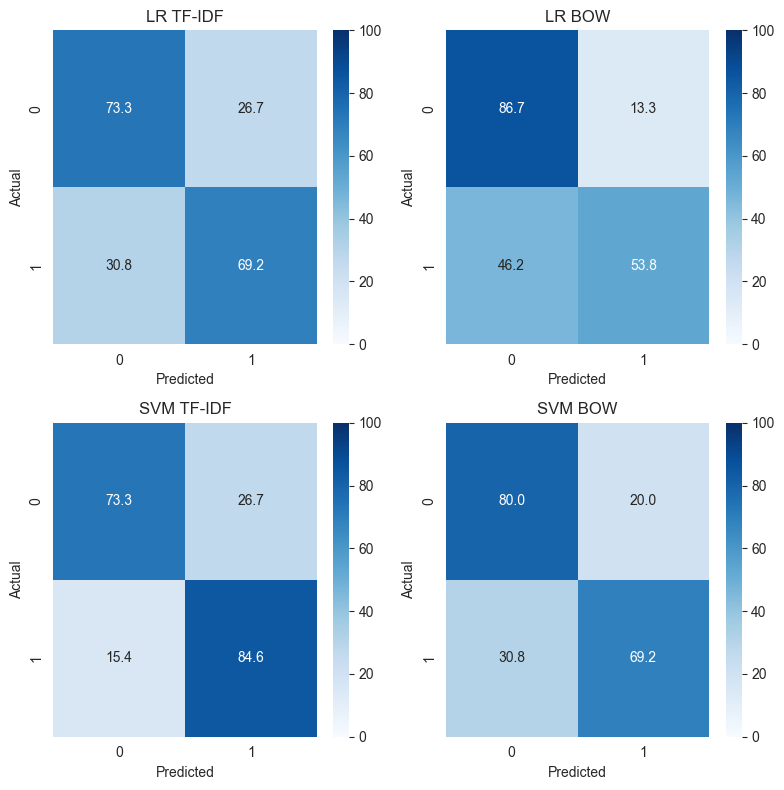

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

models = [
    ('LR TF-IDF', y_user, y_tflr),
    ('LR BOW', y_user, y_bowlr),
    ('SVM TF-IDF', y_user, y_tfsvm),
    ('SVM BOW', y_user, y_bowsvm),
]

fig, axes = plt.subplots(2, 2, figsize=(8, 8))  # 2 rows, 2 columns
axes = axes.flatten()  # flatten to easily iterate

for ax, (name, y_true, y_pred) in zip(axes, models):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
    sns.heatmap(
        cm_percent, annot=True, fmt='.1f', cmap='Blues',
        ax=ax, vmin=0, vmax=100
    )
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

Total users (after filtering): 28
mean message count: 10.5


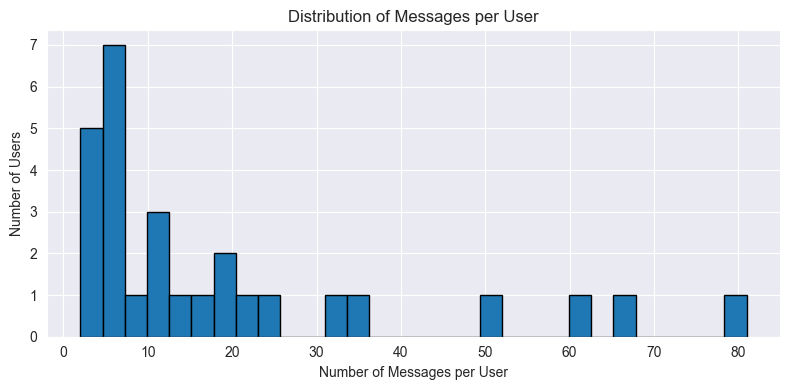

,user_id,message_count
0,91,81
1,34,66
2,79,61
3,47,51
4,55,36
5,89,31
6,16,25
7,28,22
8,77,20
9,73,19


In [16]:
messages_per_user = (
    prompts['user_id']
    .value_counts()
    .rename('message_count')
    .rename_axis('user_id')
    .reset_index()
    .sort_values('message_count', ascending=False)
)

print(f"Total users (after filtering): {len(messages_per_user)}")
print(f"mean message count: {messages_per_user['message_count'].median()}")
 # top 10 users by message count

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(messages_per_user['message_count'], bins=30, edgecolor='black')
plt.xlabel('Number of Messages per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Messages per User')
plt.tight_layout()
plt.show()

messages_per_user




## Predict on Test Data

In [86]:
import re
conn = sqlite3.connect('../../giicg.db')

test_data = pd.read_sql("SELECT * FROM masked_test_set_prompts", conn)
conn.close()
special_tokens = ["[URL]", "[CODE]", "[ID]", "[OTHER]", "[INFO]"]
# Create a regex pattern to match any of the tokens
pattern = '|'.join(re.escape(token) for token in special_tokens)

# Replace the tokens with an empty string
test_data['masked_prompt'] = test_data['masked_prompt'].str.replace(pattern, '', regex=True)
test_data['masked_prompt'] = test_data['masked_prompt'].apply(remove_punctuation_and_newlines)
test_data['masked_prompt'] = test_data['masked_prompt'].apply(remove_capitalization)

user_test_data = (
    test_data.groupby(['user_id', 'label'])['masked_prompt']
    .apply(' '.join)
    .reset_index()
)

test_data

,id,prompt,gender,label,created_at,user_id,masked_prompt
0,1,I need some python code to verify the password...,Woman (cisgender),1,2025-10-04 00:19:48,1,i need some python code to verify the password...
1,2,I want you to create a plot for weather data. ...,Woman (cisgender),1,2025-10-04 00:22:51,1,i want you to create a plot for weather data t...
2,3,Perfect. Can you add little bullet point on th...,Woman (cisgender),1,2025-10-04 00:22:51,1,perfect can you add little bullet point on the...
3,4,Can you remove the x-axis description 'Days of...,Woman (cisgender),1,2025-10-04 00:22:51,1,can you remove the xaxis description and chan...
4,5,great. Now I want to create another plot. The ...,Woman (cisgender),1,2025-10-04 00:22:51,1,great now i want to create another plot the pl...
...,...,...,...,...,...,...,...
74,75,Okay I need you to make some more adjustments....,Man (cisgender),0,2025-10-04 00:54:04,10,okay i need you to make some more adjustments ...
75,76,Okay almost! I still want lines for the x and ...,Man (cisgender),0,2025-10-04 00:54:04,10,okay almost i still want lines for the x and y...
76,77,very close. The only thing that needs to be ch...,Man (cisgender),0,2025-10-04 00:54:04,10,very close the only thing that needs to be cha...
77,78,"Great! One more thing: Remove the ""Weekdays"" t...",Man (cisgender),0,2025-10-04 00:54:04,10,great one more thing remove the term title on ...


In [87]:
import numpy as np
X_test = test_data['masked_prompt']
y_test = test_data['label']

In [45]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def estimator_metrics_to_dataframe(models_scores, X_test, y_test, class_labels):
    """
    Returns a dict of DataFrames, one per model.
    Each DataFrame contains row per estimator and columns for each metric (including per-class).
    """
    df_dict = {}
    for model_name, scores in models_scores.items():
        estimators = scores["estimator"]
        records = []
        for est in estimators:
            y_pred = est.predict(X_test)
            record = {
                "accuracy": accuracy_score(y_test, y_pred),
                "precision_weighted": precision_score(y_test, y_pred, average="weighted", zero_division=0),
                "recall_weighted": recall_score(y_test, y_pred, average="weighted", zero_division=0),
                "f1_weighted": f1_score(y_test, y_pred, average="weighted", zero_division=0),
            }
            # Per-class metrics: one column for each class and metric
            prec_class = precision_score(y_test, y_pred, labels=class_labels, average=None, zero_division=0)
            rec_class = recall_score(y_test, y_pred, labels=class_labels, average=None, zero_division=0)
            f1_class = f1_score(y_test, y_pred, labels=class_labels, average=None, zero_division=0)
            for idx, cls in enumerate(class_labels):
                record[f"precision_class_{cls}"] = prec_class[idx]
                record[f"recall_class_{cls}"] = rec_class[idx]
                record[f"f1_class_{cls}"] = f1_class[idx]
            records.append(record)
        df_dict[model_name] = pd.DataFrame(records)
    return df_dict


selected_models = {
    "Majority": maj_base_scores,
    "LR+TFIDF": tf_lr_scores,
    "LR+BoW": bow_lr_scores,
    "SVM+TFIDF": tf_svm_scores,
    "SVM+BoW": bow_svm_scores,
    "LR+TFIDF prompts": prompt_tf_lr_scores,
    "LR+BoW prompts": prompt_bow_lr_scores,
    "VM+TFIDF prompts": prompt_tf_svm_scores,
    "SVM+BoW prompts": prompt_bow_svm_scores,
}
class_labels = ['male', 'female']

metrics_dfs = estimator_metrics_to_dataframe(selected_models, X_test, y_test, class_labels)
#display(metrics_dfs["LR+TFIDF"])
metrics_dfs["SVM+BoW prompts"].describe()

,accuracy,precision_weighted,recall_weighted,f1_weighted,precision_class_male,recall_class_male,f1_class_male,precision_class_female,recall_class_female,f1_class_female
count,5.000000,5.000000,5.000000,5.000000,5.0,5.0,5.0,5.0,5.0,5.0
mean,0.491139,0.466203,0.491139,0.472732,0.0,0.0,0.0,0.0,0.0,0.0
std,0.027442,0.041694,0.027442,0.037567,0.0,0.0,0.0,0.0,0.0,0.0
min,0.468354,0.408210,0.468354,0.422672,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.468354,0.446376,0.468354,0.452955,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.481013,0.468869,0.481013,0.473119,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.506329,0.490254,0.506329,0.494497,0.0,0.0,0.0,0.0,0.0,0.0
max,0.531646,0.517306,0.531646,0.520420,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_pipelines(pipelines, pipeline_names, X_train, y_train, X_test, y_test):
    """
    Fits each pipeline to the entire training set, predicts on the test set,
    and collects all relevant metrics in a DataFrame.

    Args:
        pipelines: list of sklearn pipelines
        pipeline_names: list of strings, names matching the pipelines
        X_train, y_train: training data and labels
        X_test, y_test: test data and labels

    Returns:
        results_df: pd.DataFrame with metrics per pipeline
    """
    records = []

    for name, pipe in zip(pipeline_names, pipelines):
        # Fit and predict
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        # Accuracy
        acc = accuracy_score(y_test, y_pred)

        # Precision/Recall/F1 for each class and weighted average
        prec_0 = precision_score(y_test, y_pred, pos_label=0, average='binary', zero_division=0)
        rec_0  = recall_score(y_test, y_pred, pos_label=0, average='binary', zero_division=0)
        f1_0   = f1_score(y_test, y_pred, pos_label=0, average='binary', zero_division=0)

        prec_1 = precision_score(y_test, y_pred, pos_label=1, average='binary', zero_division=0)
        rec_1  = recall_score(y_test, y_pred, pos_label=1, average='binary', zero_division=0)
        f1_1   = f1_score(y_test, y_pred, pos_label=1, average='binary', zero_division=0)

        prec_w = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        rec_w  = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1_w   = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        row = {
            'pipeline': name,
            'accuracy': acc,
            'precision_0': prec_0,
            'recall_0': rec_0,
            'f1_0': f1_0,
            'precision_1': prec_1,
            'recall_1': rec_1,
            'f1_1': f1_1,
            'precision_weighted': prec_w,
            'recall_weighted': rec_w,
            'f1_weighted': f1_w,
        }
        records.append(row)

    results_df = pd.DataFrame.from_records(records)
    return results_df

# Example usage:
pipeline_list = [majority_base_pipe, tf_lr_pipe, bow_lr_pipe, tf_svm_pipe, bow_svm_pipe]
pipeline_names = ['majority_base_pipe', 'tf_lr_pipe', 'bow_lr_pipe', 'tf_svm_pipe', 'bow_svm_pipe']
metrics_df = evaluate_pipelines(pipeline_list, pipeline_names, X_user, y_user, X_test, y_test)
print(metrics_df)

             pipeline  accuracy  precision_0  recall_0      f1_0  precision_1  \
0  majority_base_pipe  0.582278     0.582278  1.000000  0.736000     0.000000   
1          tf_lr_pipe  0.569620     0.607143  0.739130  0.666667     0.478261   
2         bow_lr_pipe  0.582278     0.582278  1.000000  0.736000     0.000000   
3         tf_svm_pipe  0.544304     0.592593  0.695652  0.640000     0.440000   
4        bow_svm_pipe  0.607595     0.622951  0.826087  0.710280     0.555556   

   recall_1      f1_1  precision_weighted  recall_weighted  f1_weighted  
0  0.000000  0.000000            0.339048         0.582278     0.428557  
1  0.333333  0.392857            0.553306         0.569620     0.552291  
2  0.000000  0.000000            0.339048         0.582278     0.428557  
3  0.333333  0.379310            0.528851         0.544304     0.531104  
4  0.303030  0.392157            0.594798         0.607595     0.577393  


In [91]:
pipeline_list = [majority_base_pipe, tf_lr_pipe, bow_lr_pipe, tf_svm_pipe, bow_svm_pipe]
pipeline_names = ['majority_base_pipe',  'tf_lr_pipe', 'bow_lr_pipe', 'tf_svm_pipe', 'bow_svm_pipe']
metrics_df = evaluate_pipelines(pipeline_list, pipeline_names, X_prompt, y_prompt, X_test, y_test)
print(metrics_df)

             pipeline  accuracy  precision_0  recall_0      f1_0  precision_1  \
0  majority_base_pipe  0.582278     0.582278  1.000000  0.736000     0.000000   
1          tf_lr_pipe  0.544304     0.583333  0.760870  0.660377     0.421053   
2         bow_lr_pipe  0.481013     0.543860  0.673913  0.601942     0.318182   
3         tf_svm_pipe  0.531646     0.576271  0.739130  0.647619     0.400000   
4        bow_svm_pipe  0.518987     0.571429  0.695652  0.627451     0.391304   

   recall_1      f1_1  precision_weighted  recall_weighted  f1_weighted  
0  0.000000  0.000000            0.339048         0.582278     0.428557  
1  0.242424  0.307692            0.515545         0.544304     0.513053  
2  0.212121  0.254545            0.449589         0.481013     0.456827  
3  0.242424  0.301887            0.502639         0.531646     0.503199  
4  0.272727  0.321429            0.496187         0.518987     0.499619  


## ECE

In [92]:
import numpy as np
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_predict

def expected_calibration_error(y_true, y_prob, n_bins=15, strategy="uniform"):
    """
    Compute Expected Calibration Error (ECE).
    Parameters:
      y_true: array-like of shape (n_samples,), binary labels {0,1}
      y_prob: array-like of shape (n_samples,), predicted probability for the positive class
      n_bins: number of bins
      strategy: "uniform" (equal-width bins) or "quantile" (equal-size bins)
    Returns:
      float ECE
    """
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)

    if strategy == "uniform":
        bins = np.linspace(0.0, 1.0, n_bins + 1)
    elif strategy == "quantile":
        # Quantile binning based on predicted probabilities
        bins = np.quantile(y_prob, np.linspace(0.0, 1.0, n_bins + 1))
        # Ensure coverage of [0,1]
        bins[0], bins[-1] = 0.0, 1.0
        # Handle potential identical bin edges due to ties
        bins = np.unique(bins)
        # In rare cases unique quantiles < n_bins+1; fall back to uniform
        if bins.size < 3:
            bins = np.linspace(0.0, 1.0, n_bins + 1)
    else:
        raise ValueError("strategy must be 'uniform' or 'quantile'")

    # Assign each prob to a bin index in [0, n_bins-1]
    bin_indices = np.digitize(y_prob, bins[1:-1], right=True)

    ece = 0.0
    N = y_true.size
    for b in range(len(bins) - 1):
        mask = (bin_indices == b)
        n_b = np.sum(mask)
        if n_b == 0:
            continue
        acc_b = np.mean(y_true[mask])
        conf_b = np.mean(y_prob[mask])
        ece += (n_b / N) * abs(acc_b - conf_b)
    return float(ece)



strategy="uniform"
n_bins=5

cv_prediction_models = {
    "Majority": y_maj,
    "LR+TFIDF": y_tflr,
    "LR+BoW": y_bowlr,
    "SVM+TFIDF": y_tfsvm,
    "SVM+BoW": y_bowsvm,
}

cv_prompts_prediction_models = {
    "Majority prompts": prompts_y_maj,
    "LR+TFIDF_prompts": y_tflr_prompts,
    "LR+BoW_prompts": y_bowlr_prompts,
    "SVM+TFIDF_prompts": y_tfsvm_prompts,
    "SVM+BoW_prompts": y_bowsvm_prompts,
}

test_prediction_pipes = {
    "Majority": majority_base_pipe,
    "LR+TFIDF": tf_lr_pipe,
    "LR+BoW": bow_lr_pipe,
    "SVM+TFIDF": tf_svm_pipe,
    "SVM+BoW": bow_svm_pipe,
}


print("Out of fold ECEs")
for name, y_pred in cv_prediction_models.items():
    ece = expected_calibration_error(y_user, y_pred, n_bins=n_bins, strategy=strategy)
    print(f"{name}: ECE = {ece:.4f}")

print("Out of fold ECEs prompt based")
for name, y_pred in cv_prompts_prediction_models.items():
    ece = expected_calibration_error(y_prompt, y_pred, n_bins=n_bins, strategy=strategy)
    print(f"{name}: ECE = {ece:.4f}")

print("Test Set ECEs")
for name, pipe in test_prediction_pipes.items():
    pipe.fit(X_user, y_user)
    y_pred = pipe.predict(X_test)
    ece = expected_calibration_error(y_test, y_pred, n_bins=n_bins, strategy=strategy)
    print(f"{name}: ECE = {ece:.4f}")

print("Test Set fitted on Prompts ECEs")
for name, pipe in test_prediction_pipes.items():
    pipe.fit(X_prompt, y_prompt)
    y_pred = pipe.predict(X_test)
    ece = expected_calibration_error(y_test, y_pred, n_bins=n_bins, strategy=strategy)
    print(f"{name}: ECE = {ece:.4f}")
    


Out of fold ECEs
Majority: ECE = 0.4643
LR+TFIDF: ECE = 0.2857
LR+BoW: ECE = 0.2857
SVM+TFIDF: ECE = 0.2143
SVM+BoW: ECE = 0.2500
Out of fold ECEs prompt based
Majority prompts: ECE = 0.5448
LR+TFIDF_prompts: ECE = 0.4534
LR+BoW_prompts: ECE = 0.4832
SVM+TFIDF_prompts: ECE = 0.4478
SVM+BoW_prompts: ECE = 0.4739
Test Set ECEs
Majority: ECE = 0.4177
LR+TFIDF: ECE = 0.4304
LR+BoW: ECE = 0.4177
SVM+TFIDF: ECE = 0.4557
SVM+BoW: ECE = 0.3924
Test Set fitted on Prompts ECEs
Majority: ECE = 0.4177
LR+TFIDF: ECE = 0.4557
LR+BoW: ECE = 0.5190
SVM+TFIDF: ECE = 0.4684
SVM+BoW: ECE = 0.4810


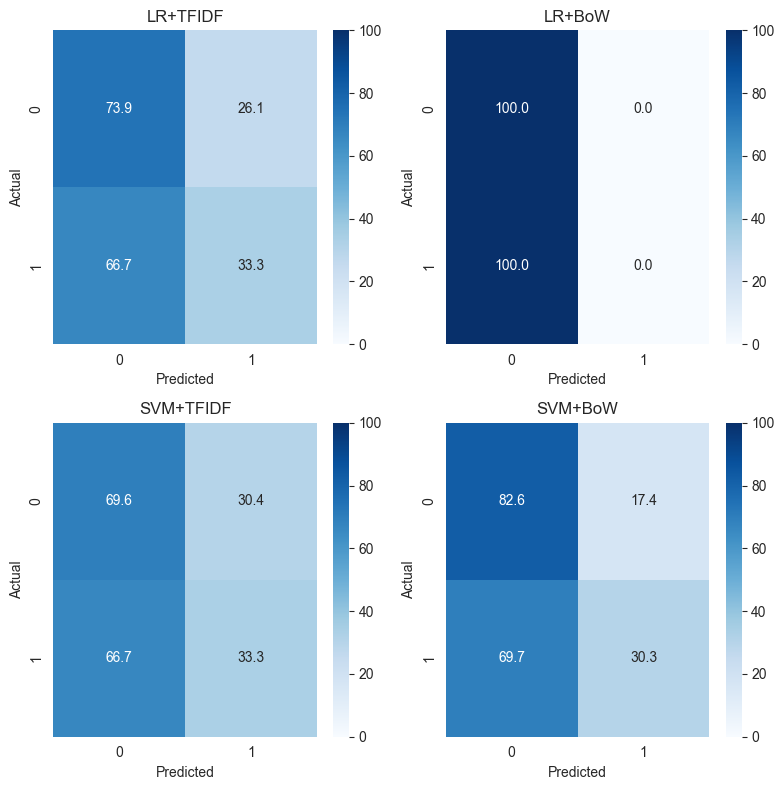

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

test_prediction_pipes = {
    #"Majority": majority_base_pipe,
    "LR+TFIDF": tf_lr_pipe,
    "LR+BoW": bow_lr_pipe,
    "SVM+TFIDF": tf_svm_pipe,
    "SVM+BoW": bow_svm_pipe,
}

predictions = {}


for name, pipe in test_prediction_pipes.items():
    # Fit and predict
    pipe.fit(X_user, y_user)
    y_pred = pipe.predict(X_test)
    predictions[name] = y_pred

y_true = y_test

fig, axes = plt.subplots(2, 2, figsize=(8, 8))  # 2 rows, 2 columns
axes = axes.flatten()  # flatten to easily iterate

for ax, (name, y_pred) in zip(axes, predictions.items()):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
    sns.heatmap(
        cm_percent, annot=True, fmt='.1f', cmap='Blues',
        ax=ax, vmin=0, vmax=100
    )
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()